# Exploration of the Berka Banking Data from the Czech Republic

In the ensuing chaos that followed the collapse of the USSR, various former Soviet satellite states experienced differing levels of financial and developmental success. Our group is interested in examining a snapshot of financial transactions and data from the Czech Republic in the 1990s after its recent independence from the USSR and its amicable separation from Slovakia. By doing so, we aim to uncover insights, intelligence, and patterns related to its financial information during this transformative period.

To facilitate a deeper understanding of the factors that lead to financial default, this project aims to uncover not only financial behaviors in the Czech Republic,  but also universal human payment default behavior as a whole. We hope to examine the relationships between transactional behaviors, account types, and customer demographics. We were inspired by previous research completed on the Berka data (Zhou Xu, 2020)

# Import all Modules used in the code

In [1]:
import pandas as pd
import os

# Module for ANOVA test for Categorical Values
from scipy.stats import f_oneway

# Import visualization modules
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium

# Reading CSV and ASC files to create project data frames

Note: Given the age of the Berka datasets, the only Macro variable found free to download was the average inflation by year. This data frame was named secondary_df

In [2]:
# Read all Berka files from the Internet if possible. NOTE: Secondary file containg inflation (drop first row, 2nd row column names)
try:
    account_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/account.asc", sep=";")
    card_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/card.asc", sep=";")
    client_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/client.asc", sep=";")
    disp_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/disp.asc", sep=";")
    district_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/district.asc", sep=";")
    loan_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/loan.asc", sep=";")
    order_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/order.asc", sep=";")
    trans_df = pd.read_csv("https://raw.githubusercontent.com/zhouxu-ds/loan-default-prediction/main/data/trans.asc", sep=";", low_memory=False)
except:
    account_df = pd.read_csv("data/account.asc", sep=";")
    card_df = pd.read_csv("data/card.asc", sep=";")
    client_df = pd.read_csv("data/client.asc", sep=";")
    disp_df = pd.read_csv("data/disp.asc", sep=";")
    district_df = pd.read_csv("data/district.asc", sep=";")
    loan_df = pd.read_csv("data/loan.asc", sep=";")
    order_df = pd.read_csv("data/order.asc", sep=";")
    trans_df = pd.read_csv("data/trans.asc", sep=";", low_memory=False)
secondary_df = pd.read_csv("data/export-20240529.csv", skiprows=1)

# Define Helper Functions

In [3]:
# Define function to format the dates. All dates imported as objects. Need to transform to datetime64
def format_date(df, date_column):
    df["YY"] = df[date_column].astype(str).str.slice(0, 2)
    df["MM"] = df[date_column].astype(str).str.slice(2, 4)
    df["DD"] = df[date_column].astype(str).str.slice(4, 6)
    df["string_date"] = "19" + df["YY"] + "-" + df["MM"] + "-" + df["DD"]
    df[str(date_column + "_formatted")] = pd.to_datetime(
        df["string_date"], format="%Y-%m-%d"
    )
    df.drop(["YY", "MM", "DD", "string_date"], axis=1, inplace=True)
    return df

In [4]:
# Define function to extract gender and age from variable birth_number in client_df. Both variables were
# numerically encoded in a single number sequence
def process_birth_number(column):
    target = column["birth_number"]
    if target // 100 % 100 > 50:
        column["gender"] = "F"
    else:
        column["gender"] = "M"
    column["age"] = 99 - (target // 10000)
    return column

In [5]:
# Define function to check for data quality in terms of zeros, blanks, missgins, and dtypes
# The function also shows key duplicates and total number of records for exploration purposes
def sanity_check(df, key):
    missings = df.isnull().sum()
    zeros = (df == 0).sum()
    blanks = (df == " ").sum()
    data_types = df.dtypes
    # Combining sets to a combined dataframe
    combined = pd.DataFrame(
        {
            "missings_values": missings,
            "zero_values": zeros,
            "blank_values": blanks,
            "data_types": data_types,
        }
    )
    print(combined)
    print(">>> Duplicates in the key", key, ": ", df[key].duplicated().sum())
    print(">>> Dataframe rows: ", len(df), "\n")

In [6]:
def cat_anova_test(df, elements):
    for element in elements:
        # Gets each variable data for each defaults/nodefault as a list
        CategoryGroupLists = df.groupby(element)["default_or_likely_default"].apply(
            list
        )
        # Performing the ANOVA test
        # We accept the Assumption(H0) only when P-Value &gt; 0.05
        AnovaResults = f_oneway(*CategoryGroupLists)
        if AnovaResults[1] > 0.05:  # alternative could be AnovaResults.pvalue
            print(
                "P-Value for Anova - variable ",
                element,
                ":",
                AnovaResults[1],
                ". Variable NOT Correlated",
            )
        else:
            print(
                "P-Value for Anova - variable ",
                element,
                ":",
                AnovaResults[1],
                ". Variable Correlated",
            )

# test described in https://thinkingneuron.com/how-to-measure-the-correlation-between-a-numeric-and-a-categorical-variable-in-python/       

# Explore Missings, Zeros and Blanks / Key duplicates and Dataset size

The objective of this section is to have a better understanding of: 1) the structure of the variables (in terms of missings, zeros, blanks, and their dtypes) in order to plan for potential variable modification, 2) Duplicates in the keys (and take that into consideration while merging), and 3) Understand the size of the data frame to ensure proper df joins.

In [7]:
# Data Quality check: Check for missings, zeros or blank values. Also see key duplicates and df rows
print("account_df")
sanity_check(account_df, "account_id")
print("card_df")
sanity_check(card_df, "card_id")
print("client_df")
sanity_check(client_df, "client_id")
print("disp_df")
sanity_check(disp_df, "account_id")
print("district_df")
sanity_check(district_df, "A1")
print("loan_df")
sanity_check(loan_df, "loan_id")
print("order_df")
sanity_check(order_df, "order_id")
print("trans_df")
sanity_check(trans_df, "trans_id")
print("secondary_df")
sanity_check(secondary_df, "Year")

account_df
             missings_values  zero_values  blank_values data_types
account_id                 0            0             0      int64
district_id                0            0             0      int64
frequency                  0            0             0     object
date                       0            0             0      int64
>>> Duplicates in the key account_id :  0
>>> Dataframe rows:  4500 

card_df
         missings_values  zero_values  blank_values data_types
card_id                0            0             0      int64
disp_id                0            0             0      int64
type                   0            0             0     object
issued                 0            0             0     object
>>> Duplicates in the key card_id :  0
>>> Dataframe rows:  892 

client_df
              missings_values  zero_values  blank_values data_types
client_id                   0            0             0      int64
birth_number                0            0       

# Explore Accounts

In [8]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
account_df.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [9]:
# Format 'date' object to datetime64 using format_date function
account_df = format_date(df=account_df, date_column="date")
# List the number of accounts by year to better understand the distribution of these accounts
account_df["date_formatted"].dt.year.value_counts().sort_index()

1993    1139
1994     439
1995     661
1996    1363
1997     898
Name: date_formatted, dtype: int64

# Explore Cards

In [10]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
card_df.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [11]:
# Format 'issued' object to datetime64. This is when the card was originally issued
card_df = format_date(df=card_df, date_column="issued")
# Show the number of cards by year (card issued year)
print(card_df["issued_formatted"].dt.year.value_counts().sort_index())
# Show the number of cards by type
print(card_df["type"].value_counts())

1993      1
1994     21
1995     63
1996    116
1997    242
1998    449
Name: issued_formatted, dtype: int64
classic    659
junior     145
gold        88
Name: type, dtype: int64


# Explore Clients

In [12]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
client_df.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [13]:
# Apply function to extract gender and age from the variable 'birth number'
client_df = client_df.apply(process_birth_number, axis=1)
# calculate summary statistics for age to how clean it is or whether we should transform it
print(client_df["age"].describe())
# Validate age and gender are in the dataset
client_df.head(2)

count    5369.000000
mean       45.801639
std        17.282283
min        12.000000
25%        31.000000
50%        45.000000
75%        59.000000
max        88.000000
Name: age, dtype: float64


,client_id,birth_number,district_id,gender,age
0,1,706213,18,F,29
1,2,450204,1,M,54


# Explore Disposition

In [14]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
# Note: each record relates together a client with an account (i.e., rights of client to operate accounts)
disp_df.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [15]:
# Need to determine whether we have authorized users ('type'='DISPONENT'). Analysis is centered
# around loan default, so cards with authorized users might be a good indicator to explore
disp_df["type"].value_counts()

OWNER        4500
DISPONENT     869
Name: type, dtype: int64

In [16]:
# Feature Engineering: We want to compare accounts where there is an authorized user vs the ones
# with no authorized users in terms of default. New variable added: user_flag

# Create a flag to indicate whether there is a 'DISPONENT' (authorized user) for each account
disp_df["user_flag"] = disp_df.groupby("account_id")["type"].transform(
    lambda x: "DISPONENT" in x.values
)

# Filter the dataframe to keep only rows where type is 'OWNER'. Deep copy to avoid warnings during joins
disp_df = disp_df[disp_df["type"] == "OWNER"].copy()

# Validate 'user_flag' records. Compare vs the 869 count in the previous cell
print(
    "Number of customers with authorized users in their cards: ",
    disp_df["user_flag"].sum(),
)

# Ensure changes are incorporated in the dataset
disp_df.head(3)

Number of customers with authorized users in their cards:  869


,disp_id,client_id,account_id,type,user_flag
0,1,1,1,OWNER,False
1,2,2,2,OWNER,True
3,4,4,3,OWNER,True


# Explore Districts (i.e., Demographic Data)

In [17]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
district_df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [18]:
# Renaming variables for better a content description (based on data dictionary)
district_df.rename(
    columns={
        "A1": "District_code",
        "A2": "District_name",
        "A3": "Region",
        "A4": "Number_of_inhabitants",
        "A5": "Municipalities_lt_499",
        "A6": "Municipalities_500_to_1999",
        "A7": "Municipalities_2000_9999",
        "A8": "Municipalities_gt_10000",
        "A9": "Number_of_cities",
        "A10": "Ratio_of_Urban_Inhabitants",
        "A11": "Average_Salary",
        "A12": "Unemployment_rate_1995",
        "A13": "Unemployment_rate_1996",
        "A14": "Number_of_entrepreneurs_per_1000",
        "A15": "Number_of_crimes_1995",
        "A16": "Number_of_crimes_1996",
    },
    inplace=True,
)

In [19]:
# Visually inspect results from renaming
district_df.head(2)

,District_code,District_name,Region,Number_of_inhabitants,Municipalities_lt_499,Municipalities_500_to_1999,Municipalities_2000_9999,Municipalities_gt_10000,Number_of_cities,Ratio_of_Urban_Inhabitants,Average_Salary,Unemployment_rate_1995,Unemployment_rate_1996,Number_of_entrepreneurs_per_1000,Number_of_crimes_1995,Number_of_crimes_1996
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674


# Explore Loans

In [20]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
loan_df.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [21]:
# Transform loan date to datetime64
loan_df = format_date(df=loan_df, date_column="date")

# Explore loan statuses to understand the population available for the anaylsis and default volume
loan_df["status"].value_counts()
# 'A' stands for contract finished, no problems
# 'B' stands for contract finished, loan not payed
# 'C' stands for running contract, OK so far
# 'D' stands for running contract, client in debt

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [22]:
# Create the variable that defines default. True= Default
# IMPORTANT: Total # of loans is 682 out of which 76 defaulted (11.14%)
loan_df["default_or_likely_default"] = loan_df["status"].isin(["D", "B"])

# Explore results
loan_df.head()

,loan_id,account_id,date,amount,duration,payments,status,date_formatted,default_or_likely_default
0,5314,1787,930705,96396,12,8033.0,B,1993-07-05,True
1,5316,1801,930711,165960,36,4610.0,A,1993-07-11,False
2,6863,9188,930728,127080,60,2118.0,A,1993-07-28,False
3,5325,1843,930803,105804,36,2939.0,A,1993-08-03,False
4,7240,11013,930906,274740,60,4579.0,A,1993-09-06,False


# Explore Orders

In [23]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
# Orders contain transfers to other accounts/banks from the customer account. Can be own loans
order_df.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [24]:
# Undestand the types of transfer for potential new features
order_df["k_symbol"].value_counts()
# 'POJISTNE' stands for insurance payment
# 'SIPO'     stands for household payment
# 'LEASING'  stands for leasing
# 'UVER'     stands for loan payment
# ''

SIPO        3502
            1379
UVER         717
POJISTNE     532
LEASING      341
Name: k_symbol, dtype: int64

In [25]:
# Subset just order that are loan payments
loan_payments_df = order_df[(order_df["k_symbol"] == "UVER")]

# Feature engineering - sum up all loan payments by account
loan_payments_by_account_df = (
    loan_payments_df[["account_id", "amount"]].groupby("account_id").sum().reset_index()
)
loan_payments_by_account_df.rename(
    columns={"amount": "sum_of_loan_payments"}, inplace=True
)

# Explore results. Not all accounts have loans and not all accounts with loans have registered payments
loan_payments_by_account_df.head(3)

,account_id,sum_of_loan_payments
0,2,3372.7
1,19,2523.2
2,25,2523.2


# Explore Transactions

In [26]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [27]:
# Transform transactions date to datetime64
trans_df = format_date(df=trans_df, date_column="date")

# Feature engineering - count up the number of all transactions by account
trans_counts_by_account_df = (
    trans_df[["account_id", "amount"]].groupby("account_id").count().reset_index()
)
trans_counts_by_account_df.rename(
    columns={"amount": "count_transactions"}, inplace=True
)

# Subset just transactions that are withdrawals
trans_withdrawal_df = trans_df[(trans_df["type"] == "VYDAJ")]

# Feature engineering - count withdrawals
trans_count_withdrawal_df = (
    trans_withdrawal_df[["account_id", "amount"]]
    .groupby("account_id")
    .count()
    .reset_index()
)
trans_count_withdrawal_df.rename(columns={"amount": "count_withdrawals"}, inplace=True)

# Feature engineering - max withdrawals
trans_max_withdrawal_df = (
    trans_withdrawal_df[["account_id", "amount"]]
    .groupby("account_id")
    .max()
    .reset_index()
)
trans_max_withdrawal_df.rename(columns={"amount": "max_withdrawal"}, inplace=True)

# Aggregating the three features by account_id Summarize transactions
trans_summary_df = trans_counts_by_account_df.merge(
    trans_count_withdrawal_df, on="account_id", how="left"
).merge(trans_max_withdrawal_df, on="account_id", how="left")
trans_summary_df.head()

,account_id,count_transactions,count_withdrawals,max_withdrawal
0,1,239,137,7500.0
1,2,478,305,42000.0
2,3,117,71,7400.0
3,4,186,121,5250.0
4,5,84,49,5100.0


# Explore Secondary Dataset (with inflation)

In [28]:
# Visually explore data before any transformations, feature engineering, filtering, etc.
secondary_df.head(3)

,Year,Inflation Rate (%),Annual Change
0,2022,15.10%,11.26%
1,2021,3.84%,0.68%
2,2020,3.16%,0.31%


In [29]:
# Need to transform inflation rate to float(first clean % sign), then sort by Year so that the lag
# is created properly. Drop 'Annual Change' and rename columns to be used and merged. 'Year' will be the key

# changing 'Inflation Rate (%)' dtype to float64
secondary_df["Inflation Rate (%)"] = (
    secondary_df["Inflation Rate (%)"].str.replace("%", "").astype(float)
)

# Sorting the secondary_df by 'Year' in ascending order before the lag
secondary_df = secondary_df.sort_values(by="Year", ascending=True)

# Create lagged column based on 'Inflation rate (%)'. Lag 1 represent a 12 month lag because these are annual metrics
secondary_df["Inflation_rate_lag12months"] = secondary_df["Inflation Rate (%)"].shift(1)

# Drop the 'Annual Change' column
secondary_df = secondary_df.drop(columns=["Annual Change"])

# Rename 'Inflation Rate (%)' to 'Inflation_rate' and 'Year' to 'secondary_Year_id'
secondary_df = secondary_df.rename(
    columns={"Inflation Rate (%)": "Inflation_rate", "Year": "secondary_Year_id"}
)

secondary_df[-5:]

,secondary_Year_id,Inflation_rate,Inflation_rate_lag12months
4,2018,2.15,2.45
3,2019,2.85,2.15
2,2020,3.16,2.85
1,2021,3.84,3.16
0,2022,15.10,3.84


# Join Datasets

In [30]:
# Let's rename some columns in the source data and drop unnecessary columns (e.g. raw dates)

account_df.rename(
    columns={
        "district_id": "account_district_id",
        "date_formatted": "account_date_formatted",
    },
    inplace=True,
)
account_df.drop(columns=["date"], inplace=True)

client_df.rename(columns={"district_id": "client_district_id"}, inplace=True)
client_df.drop(columns=["birth_number"], inplace=True)

card_df.rename(
    columns={"type": "card_type", "issued_formatted": "card_issued_formatted"},
    inplace=True,
)
card_df.drop(columns=["issued"], inplace=True)

loan_df.rename(
    columns={
        "date_formatted": "loan_date_formatted",
        "amount": "loan_amount",
        "duration": "loan_duration",
        "payments": "loan_payments",
    },
    inplace=True,
)
loan_df.drop(columns=["date"], inplace=True)

disp_df.drop(columns=["type"], inplace=True)

In [31]:
# Left join dispositions with accounts and clients
# Each record in disposition relates together a client with an account (i.e. the rights of clients to operate an account)
disp_account_client_df = disp_df.merge(account_df, on="account_id", how="left").merge(
    client_df, on="client_id", how="left"
)

In [32]:
# Left join the result with the cards - note that not every disposition (account and client relation) has a card
disp_account_client_card_df = disp_account_client_df.merge(
    card_df, on="disp_id", how="left"
)

In [33]:
# Left join the account owners to the loan data. Analysis will be performed around loans, based on
# previous results, we have 682 loans from which 76 are considered defaults
loan_account_owners = loan_df.merge(
    disp_account_client_card_df, on="account_id", how="left"
)

In [34]:
# Left join districts to the loan data (adding demographic data at the district level)
loan_account_owners_district = loan_account_owners.merge(
    district_df, left_on="account_district_id", right_on="District_code", how="left"
)

In [35]:
# Left join the summarized transactions to the loan data. Raw transactions file is not used, only new features
loan_account_owners_district_trans = loan_account_owners_district.merge(
    trans_summary_df, on="account_id", how="left"
)

In [36]:
# Left join the summarized orders (loan payments) to the loan data. loan_payments_by_account_df is a summarized sub-dataset
# of order_df.
final_merged_df = loan_account_owners_district_trans.merge(
    loan_payments_by_account_df, on="account_id", how="left"
)

In [37]:
# Left join the secondary dataset(inflation data) to the final_merged_df (based on year of loan origination)

# First extract the year from 'loan_date_formatted' in final_merged_df. To be used as key for the join
final_merged_df["loan_year_id"] = pd.to_datetime(
    final_merged_df["loan_date_formatted"]
).dt.year

# Left join on the 'loan_year_id' and 'Year' columns
final_merged_df = final_merged_df.merge(
    secondary_df, left_on="loan_year_id", right_on="secondary_Year_id", how="left"
)

final_merged_df.columns

Index(['loan_id', 'account_id', 'loan_amount', 'loan_duration',
       'loan_payments', 'status', 'loan_date_formatted',
       'default_or_likely_default', 'disp_id', 'client_id', 'user_flag',
       'account_district_id', 'frequency', 'account_date_formatted',
       'client_district_id', 'gender', 'age', 'card_id', 'card_type',
       'card_issued_formatted', 'District_code', 'District_name', 'Region',
       'Number_of_inhabitants', 'Municipalities_lt_499',
       'Municipalities_500_to_1999', 'Municipalities_2000_9999',
       'Municipalities_gt_10000', 'Number_of_cities',
       'Ratio_of_Urban_Inhabitants', 'Average_Salary',
       'Unemployment_rate_1995', 'Unemployment_rate_1996',
       'Number_of_entrepreneurs_per_1000', 'Number_of_crimes_1995',
       'Number_of_crimes_1996', 'count_transactions', 'count_withdrawals',
       'max_withdrawal', 'sum_of_loan_payments', 'loan_year_id',
       'secondary_Year_id', 'Inflation_rate', 'Inflation_rate_lag12months'],
      dtype='obj

# Visualize Features related to Loan Defaults

### Numeric Variables Correlation 

In [38]:
# Data preparation for the numeric variables correlation
# Correlation using the numeric values in the final dataset
# Capture descriptive statistics in a df (another way to get numeric cols is df.select_dtypes(include='number')
desc = final_merged_df.describe()

# Dropping some columns that would not show any meaningful value in the correlation (ids and dates)
cols_to_drop = desc.filter(regex="_id$|_formatted$").columns
df_cleaned = desc.drop(columns=cols_to_drop)

# Keep numeric columns from descriptive statistics
numeric_columns = df_cleaned.columns

num_correlations = (
    final_merged_df[numeric_columns]
    .corrwith(final_merged_df["default_or_likely_default"])
    .sort_values()
)
corr_df = num_correlations.reset_index()
corr_df.columns = ["variables", "correlation"]

corr_df.head()

,variables,correlation
0,Number_of_entrepreneurs_per_1000,-0.046420
1,Municipalities_2000_9999,-0.042940
2,Number_of_cities,-0.037178
3,Average_Salary,-0.034555
4,Number_of_crimes_1996,-0.027963


In [39]:
# Adjusting correlations to show only 3 decimals (to be displayed next to each bar)
corr_df["correlation"] = round(corr_df["correlation"], 3)
corr_df = corr_df.copy()
# Create the Altair plot
base_corr = alt.Chart(corr_df).encode(
    x=alt.X("variables:O", title="Variable", sort=None),
    y=alt.Y("correlation:Q", title="Correlation"),
)

# Text layer with correlation labels
text_corr = base_corr.mark_text(align="center", dx=-3).encode(
    text="correlation",
    color=alt.condition(
        alt.datum.correlation > 0,
        alt.value("green"),  # Positive correlation
        alt.value("red"),  # Negative correlation
    ),
)

# Mark layer on the right with correlationneera values and color tempertature
mark_corr = base_corr.mark_bar().encode(
    color=alt.Color("correlation:Q", scale=alt.Scale(domain=(-1, 1), scheme="redblue"))
)

# Combine the text and mark layers
chart = mark_corr + text_corr
# Size change to the assembled chart and adding inteactive mode
chart.properties(
    width=700,
    height=350,
    title="Correlation between Numeric Variables and  Default (or Likely Default)",
).interactive()

alt.LayerChart(...)

In [40]:
# Running the one-way ANOVA test between Categorical Vars and Defaults
# NOTE: Assumption(H0) is that Categorical Var and Target are NOT correlated
cat_vars = ["Region", "gender", "card_type"]
cat_anova_test(final_merged_df, cat_vars)

P-Value for Anova - variable  Region : 0.15391658015974363 . Variable NOT Correlated
P-Value for Anova - variable  gender : 0.5895678129551464 . Variable NOT Correlated
P-Value for Anova - variable  card_type : 0.5883619470571322 . Variable NOT Correlated


Text(0.5, 1.0, 'Distribution of Sum of Loan Payments by Account')

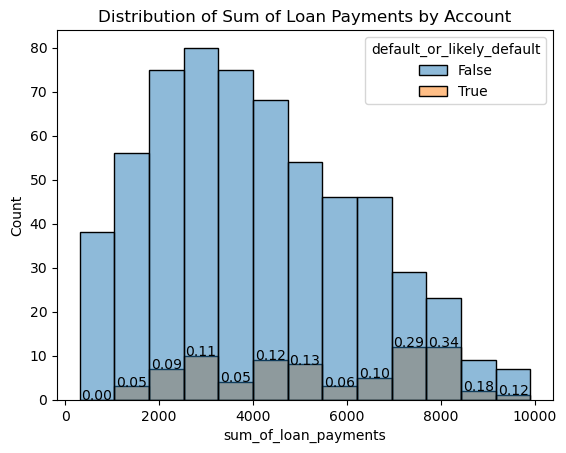

In [41]:
# Account owners making higher loan payments (likely due to higher loans) are more likely to default
ax = sns.histplot(
    data=final_merged_df,
    x="sum_of_loan_payments",
    hue="default_or_likely_default",
    kde=False,
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Distribution of Sum of Loan Payments by Account")

Text(0.5, 1.0, 'Distribution of Loan Payments by Account')

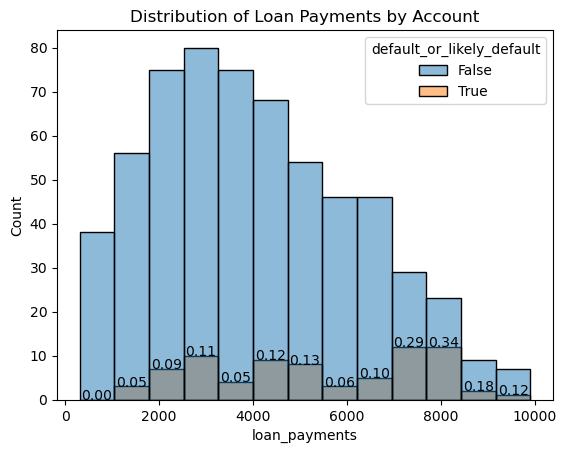

In [42]:
# Histogram of Loan Payments and Default Status - higher loan payments are more associated with default
# This is the most correlated variable to default (loan_payments and sum_of_loan_payments almost same
# variable). Several breaks in the bad rate pattern, but
ax = sns.histplot(
    data=final_merged_df, x="loan_payments", hue="default_or_likely_default", kde=False
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Distribution of Loan Payments by Account")

Text(0.5, 1.0, 'Histogram of Loan Amount and Default Status')

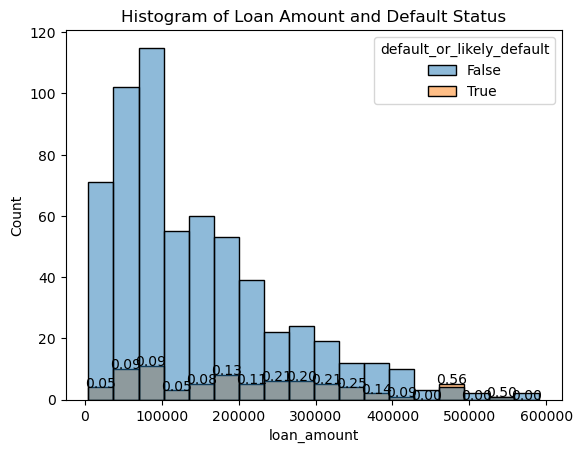

In [43]:
# Histogram of Loan Amount and Default Status - higher loan amounts are more associated with default
# This variables showed the 3rd highest correlation. Not perfectly monotonic but there is a clear
# descending pattern in loss rates
ax = sns.histplot(
    data=final_merged_df, x="loan_amount", hue="default_or_likely_default", kde=False
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Histogram of Loan Amount and Default Status")

Text(0.5, 1.0, 'Distribution of Days from Account Creation to Loan Granted')

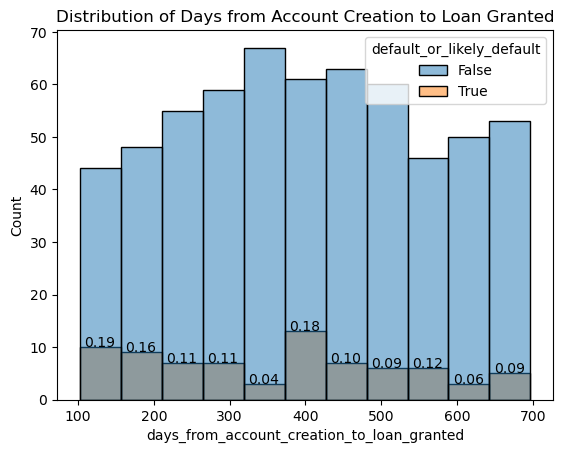

In [44]:
# Engineer a new feature of the days from account creation to loan granted
final_merged_df["days_from_account_creation_to_loan_granted"] = (
    final_merged_df["loan_date_formatted"] - final_merged_df["account_date_formatted"]
).dt.days

ax = sns.histplot(
    data=final_merged_df,
    x="days_from_account_creation_to_loan_granted",
    hue="default_or_likely_default",
    kde=False,
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Distribution of Days from Account Creation to Loan Granted")

Text(0.5, 1.0, 'Distribution of Max Withdrawal in Transactions History by Account')

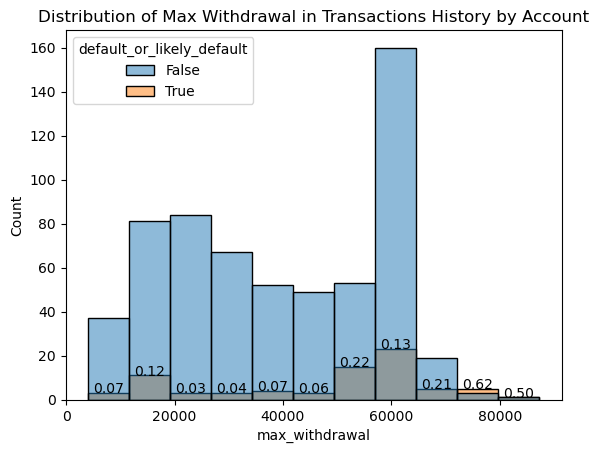

In [45]:
# Account owners with high maximum withdrawals in their history of transactions are more likely to default
ax = sns.histplot(
    data=final_merged_df, x="max_withdrawal", hue="default_or_likely_default", kde=False
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Distribution of Max Withdrawal in Transactions History by Account")

<Axes: xlabel='gender'>

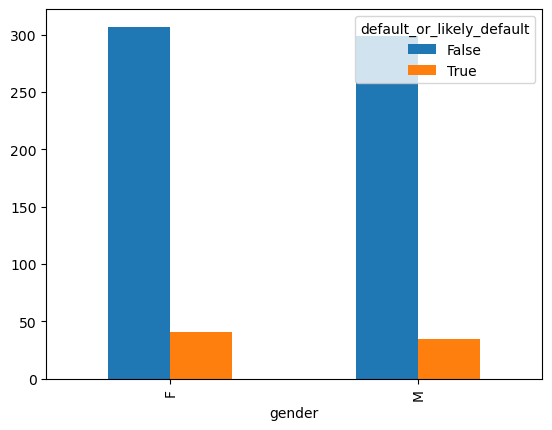

In [46]:
# Relationship between the Gender of Account Owner and Default Status - there is no apparent pattern
# This relationship was confirmed by the Anove test
pd.crosstab(
    final_merged_df["gender"], final_merged_df["default_or_likely_default"]
).plot.bar(stacked=False)

Text(0.5, 1.0, 'Histogram of Age of the Account Owner by Default Status')

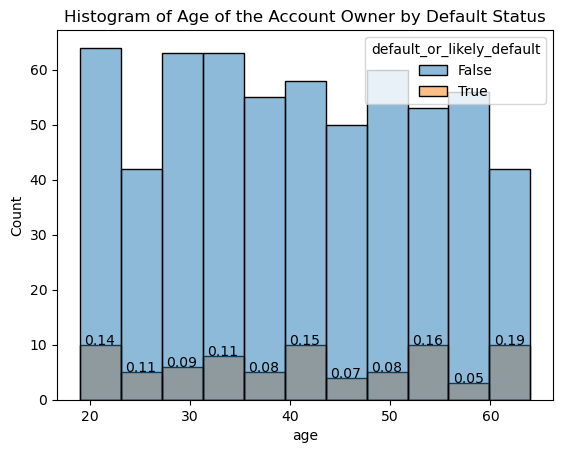

In [47]:
# Histogram of Age of the Account Owner by Default Status - there is no apparent pattern
# Similar to gender, ANOVA confirmed no correlation
ax = sns.histplot(
    data=final_merged_df, x="age", hue="default_or_likely_default", kde=False
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Histogram of Age of the Account Owner by Default Status")

Text(0.5, 1.0, 'Scatter Plot of Account by Loan Amount vs. Loan Payments and their Default Status')

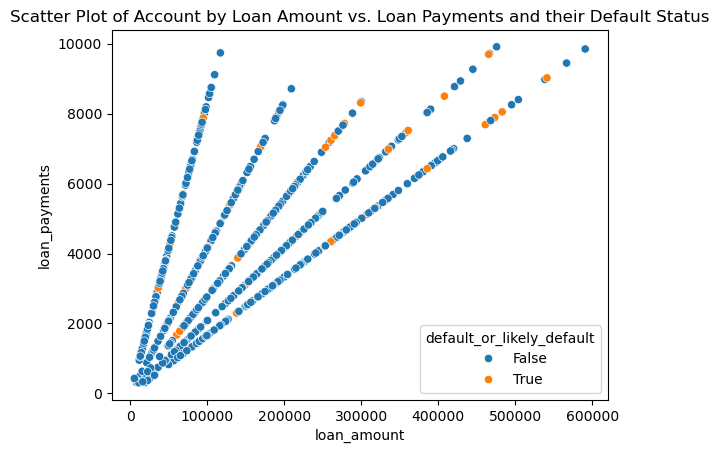

In [48]:
# Visualizing Size of a Loan and size of Payment along defaults. We can identify five tiers that
# seem to be associated to interest rates
sns.scatterplot(
    data=final_merged_df,
    x="loan_amount",
    y="loan_payments",
    hue="default_or_likely_default",
).set_title(
    "Scatter Plot of Account by Loan Amount vs. Loan Payments and their Default Status"
)

Text(0.5, 1.0, 'Kernel Density Plot of Contours of Loan Amount and Loan Payment by Default Status')

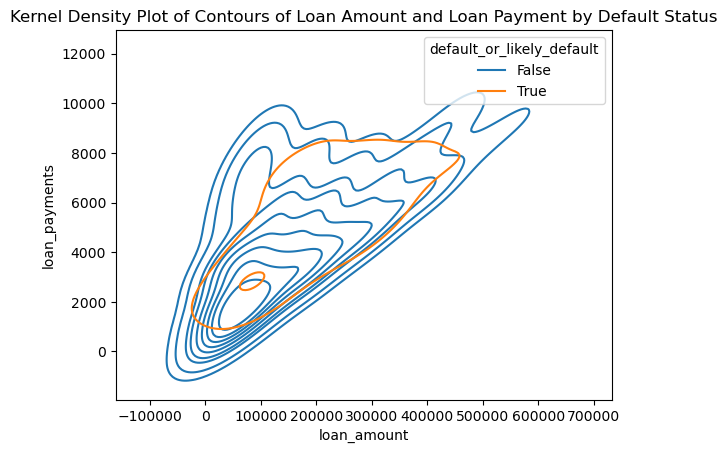

In [49]:
# Kernel Density Plot of Contours of Loan Amount and Loan Payment by Default Status
# Defaulters tend to have higher loan amounts and loan payments
sns.kdeplot(
    data=final_merged_df,
    x="loan_amount",
    y="loan_payments",
    hue="default_or_likely_default",
    fill=False,
).set_title(
    "Kernel Density Plot of Contours of Loan Amount and Loan Payment by Default Status"
)

default_or_likely_default  card_type
False                      classic      130
                           junior        20
                           gold          15
True                       classic        3
                           gold           1
                           junior         1
Name: card_type, dtype: int64


<Axes: xlabel='card_type'>

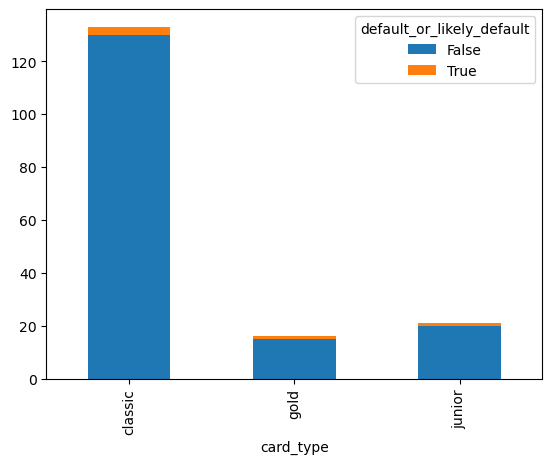

In [50]:
# Relationship between Card Type and Default Status
# Junior cards may have a higher default rate, but we have very limited data on credit cards
# This means that only about a quarter of customers with loans have a card and bad rates for those
# customers is only 2.9, compared to 11.14 to all loan population
print(
    final_merged_df.groupby(by="default_or_likely_default")["card_type"].value_counts()
)
pd.crosstab(
    final_merged_df["card_type"], final_merged_df["default_or_likely_default"]
).plot.bar(stacked=True)

[Text(0, 0, 'west Bohemia'),
 Text(1, 0, 'east Bohemia'),
 Text(2, 0, 'central Bohemia'),
 Text(3, 0, 'Prague'),
 Text(4, 0, 'south Bohemia'),
 Text(5, 0, 'south Moravia'),
 Text(6, 0, 'north Moravia'),
 Text(7, 0, 'north Bohemia')]

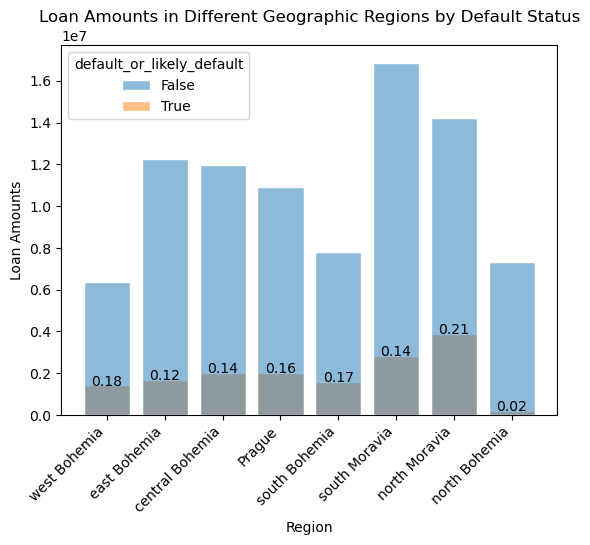

In [51]:
# Different regions of the Czech Republic have different loan default rates
# Region did not show correlation with ANOVA. Results below confirm this for the most part
# The only thing to highlight here is the very low bad rate in North Bohemia
ax = sns.histplot(
    final_merged_df,
    x="Region",
    weights="loan_amount",
    hue="default_or_likely_default",
    edgecolor="white",
    shrink=0.8,
)
heights = [h.get_height() for h in ax.patches]
half = int(round(len(heights) / 2, 0))
true_values = heights[0:half]
false_values = heights[half : len(heights)]
total_values = list(np.array(true_values) + np.array(false_values))
bad_rate = list(np.array(true_values) / np.array(total_values))
patches = ax.patches
for i in range(len(bad_rate)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate("{:.2f}".format(bad_rate[i]), (x, y), ha="center")
ax.set_title("Loan Amounts in Different Geographic Regions by Default Status")
ax.set_ylabel("Loan Amounts")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

In [52]:
# Display a map of the Czech Republic
# Tried to show bad rates by color, but given the changes in geography since this data was provided,
# we could not add that dimention (boundaries have changed).
import folium as folium

FoliumFigure = folium.Figure(width=800, height=500)
CzechMap = folium.Map(
    location=[50, 15],
    titles="openstreetmap",
    scrollWheelZoom=False,
    dragging=False,
    zoom_control=False,
    zoom_start=7,
    min_zoom=7,
    max_zoom=7,
    max_bounds=True,
).add_to(FoliumFigure)
CzechMap

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2f3859f7-f67c-47af-902f-3ba4997533f9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>